<a href="https://colab.research.google.com/github/Rojan116/Track/blob/master/Behavioral_cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Rojan116/Track

fatal: destination path 'Track' already exists and is not an empty directory.


In [2]:
!ls Track

driving_log.csv  IMG


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Dense, Flatten
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
import ntpath
import os

In [4]:
datadir = 'Track'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth',-1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/home/rojan/Desktop/Data/IMG/center_2019_04_19_19_12_23_291.jpg,/home/rojan/Desktop/Data/IMG/left_2019_04_19_19_12_23_291.jpg,/home/rojan/Desktop/Data/IMG/right_2019_04_19_19_12_23_291.jpg,0.0,0.0,0.0,0.000078
1,/home/rojan/Desktop/Data/IMG/center_2019_04_19_19_12_23_384.jpg,/home/rojan/Desktop/Data/IMG/left_2019_04_19_19_12_23_384.jpg,/home/rojan/Desktop/Data/IMG/right_2019_04_19_19_12_23_384.jpg,0.0,0.0,0.0,0.000078
2,/home/rojan/Desktop/Data/IMG/center_2019_04_19_19_12_23_485.jpg,/home/rojan/Desktop/Data/IMG/left_2019_04_19_19_12_23_485.jpg,/home/rojan/Desktop/Data/IMG/right_2019_04_19_19_12_23_485.jpg,0.0,0.0,0.0,0.000081
3,/home/rojan/Desktop/Data/IMG/center_2019_04_19_19_12_23_589.jpg,/home/rojan/Desktop/Data/IMG/left_2019_04_19_19_12_23_589.jpg,/home/rojan/Desktop/Data/IMG/right_2019_04_19_19_12_23_589.jpg,0.0,0.0,0.0,0.000078
4,/home/rojan/Desktop/Data/IMG/center_2019_04_19_19_12_23_696.jpg,/home/rojan/Desktop/Data/IMG/left_2019_04_19_19_12_23_696.jpg,/home/rojan/Desktop/Data/IMG/right_2019_04_19_19_12_23_696.jpg,0.0,0.0,0.0,0.000079


In [5]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_04_19_19_12_23_291.jpg,left_2019_04_19_19_12_23_291.jpg,right_2019_04_19_19_12_23_291.jpg,0.0,0.0,0.0,0.000078
1,center_2019_04_19_19_12_23_384.jpg,left_2019_04_19_19_12_23_384.jpg,right_2019_04_19_19_12_23_384.jpg,0.0,0.0,0.0,0.000078
2,center_2019_04_19_19_12_23_485.jpg,left_2019_04_19_19_12_23_485.jpg,right_2019_04_19_19_12_23_485.jpg,0.0,0.0,0.0,0.000081
3,center_2019_04_19_19_12_23_589.jpg,left_2019_04_19_19_12_23_589.jpg,right_2019_04_19_19_12_23_589.jpg,0.0,0.0,0.0,0.000078
4,center_2019_04_19_19_12_23_696.jpg,left_2019_04_19_19_12_23_696.jpg,right_2019_04_19_19_12_23_696.jpg,0.0,0.0,0.0,0.000079


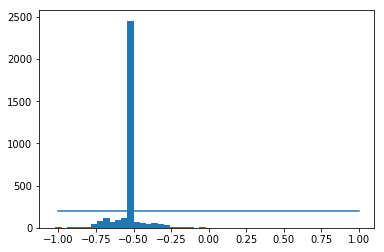

In [6]:
num_bins  = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'],num_bins) 
center = (bins[:-1]+bins[:1])*0.5
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

total data 3350
removed 2254
Remaining data 1096


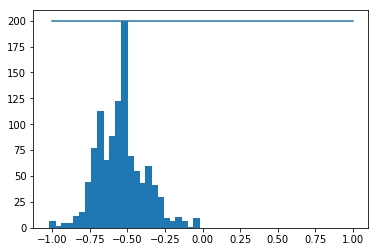

In [9]:
print('total data',len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)  
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
  
print('removed',len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('Remaining data', len(data))

hist,_ =np.histogram(data['steering'],(num_bins))

plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))
    

In [16]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)): 
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))
  image_path = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_path, steerings


image_paths, steerings =  load_img_steering(datadir +'/IMG',  data)

center      center_2019_04_19_19_12_24_734.jpg
left        left_2019_04_19_19_12_24_734.jpg  
right       right_2019_04_19_19_12_24_734.jpg 
steering   -0.351477                          
throttle    0.697104                          
reverse     0                                 
speed       1.06838                           
Name: 13, dtype: object


In [17]:
x_train, x_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training samples: {}\n Valid Samples : {}'.format(len(x_train),len(x_valid)))

Training samples: 876
 Valid Samples : 220


Text(0.5, 1.0, 'Validation  set')

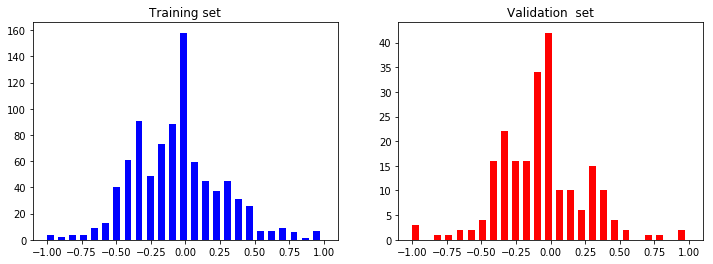

In [18]:
fig , axis = plt.subplots(1,2,figsize=(12,4))
axis[0].hist(y_train, bins=num_bins, width=0.05,color='blue')
axis[0].set_title("Training set")
axis[1].hist(y_valid, bins=num_bins, width=0.05,color='red')
axis[1].set_title("Validation  set")


In [0]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135,: ,:]
  img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img,(3,3), 0)
  img = cv2.resize(img, (200,66))
  img = img/255
  return img

Text(0.5, 1.0, 'Processed image')

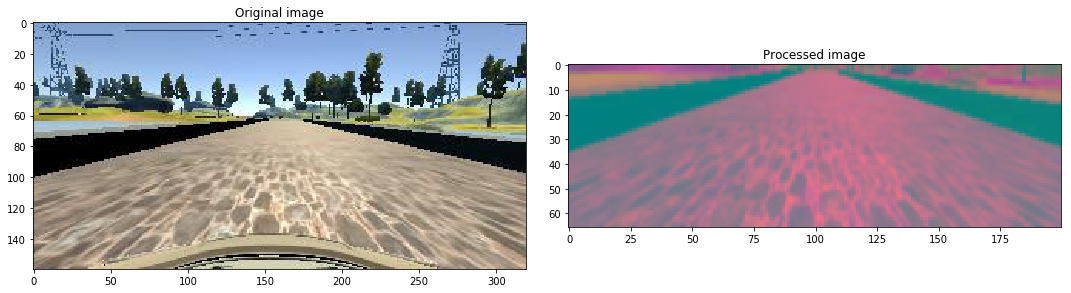

In [39]:
image = image_paths[150]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig , axis = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title("Original image")
axis[1].imshow(preprocessed_image)
axis[1].set_title("Processed image")

In [0]:
x_train = np.array(list(map(img_preprocess, x_train)))
x_valid = np.array(list(map(img_preprocess, x_valid)))



(876, 66, 200, 3)


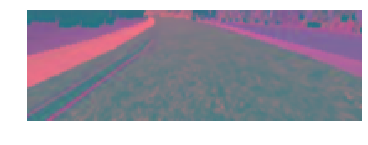

In [43]:
plt.imshow(x_train[random.randint(0,len(x_train)-1)])
plt.axis('off')
print(x_train.shape)

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2,2), input_shape=(66,200,3), activation='elu'))
  model.add(Convolution2D(36, 5,5, subsample=(2,2), activation='elu'))
  model.add(Convolution2D(48, 5,5, subsample=(2,2), activation='elu'))
  model.add(Convolution2D(64, 3,3, activation='elu'))
  model.add(Convolution2D(64, 3,3, activation='elu'))
  model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  model.add(Dense(100,activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50,activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(10,activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model
  
  

In [57]:
model= nvidia_model()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1152)              0         
__________

In [58]:
history = model.fit(x_train, y_train, epochs=30, validation_data = (x_valid,y_valid), batch_size=100, verbose=1,shuffle=1)

Train on 876 samples, validate on 220 samples
Epoch 1/30
876/876 [==============================] - 1s 1ms/step - loss: 0.8693 - val_loss: 0.0989
Epoch 2/30
876/876 [==============================] - 0s 553us/step - loss: 0.3376 - val_loss: 0.1107
Epoch 3/30
876/876 [==============================] - 0s 473us/step - loss: 0.1766 - val_loss: 0.0894
Epoch 4/30
876/876 [==============================] - 0s 436us/step - loss: 0.1258 - val_loss: 0.0896
Epoch 5/30
876/876 [==============================] - 0s 430us/step - loss: 0.1263 - val_loss: 0.0859
Epoch 6/30
876/876 [==============================] - 0s 415us/step - loss: 0.1140 - val_loss: 0.0846
Epoch 7/30
876/876 [==============================] - 0s 414us/step - loss: 0.1112 - val_loss: 0.0829
Epoch 8/30
876/876 [==============================] - 0s 403us/step - loss: 0.1042 - val_loss: 0.0810
Epoch 9/30
876/876 [==============================] - 0s 416us/step - loss: 0.1026 - val_loss: 0.0800
Epoch 10/30
876/876 [=================

/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 'T' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/usr/local/lib/python3.6/dist-packages/matp

Text(0.5, 0, 'Epoch')

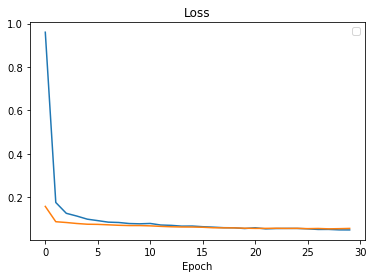

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend('Training', 'Validation')
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')